# EYE FOR BLIND ( Encoder-Decoder & Attention Models )
In this project, we need to create a deep learning model which can explain the contents of an image in the form of speech through caption generation with an attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library.



This problem statement is an application of both deep learning and natural language processing. The features of an image will be extracted by a CNN-based encoder and this will be decoded by an RNN model.


- The project is an extended application of Show, Attend and Tell: Neural Image Caption Generation with Visual Attention paper.

## Step 1 : Lets Import required Libraries

In [1]:
#Import all the required libraries
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import os
pd.set_option('display.max_colwidth',100)



2025-09-30 09:14:11.679134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759223651.876068      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759223651.930692      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 2: Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [3]:
#Importing the dataset to read the image into a seperate variable

DATA_DIR = '/kaggle/input/flickr8k'
IMAGES_DIR = os.path.join(DATA_DIR,'Images')
CAPTIONS_FILE = os.path.join(DATA_DIR,'captions.txt')
OUTPUT_IMAGE_PATH = "../working/Image/"

all_imgs = glob.glob(IMAGES_DIR+ '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


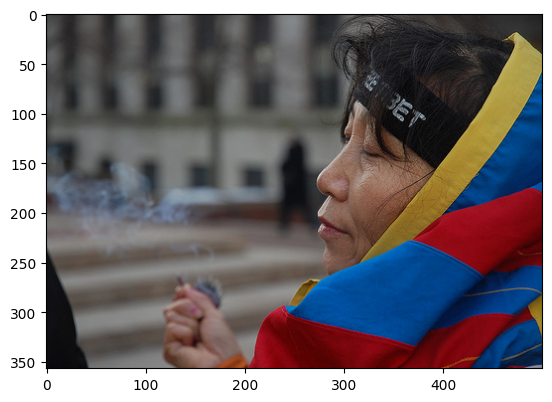

In [4]:
#Visualise both the images & text present in the dataset
plt.imshow(mpimg.imread(all_imgs[109]))
plt.show()

In [5]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):

    #your code here
    with open(filename,'r') as f:
        text=list(filter(None,(line.rstrip() for line in f)))

    return text

doc = load_doc(CAPTIONS_FILE)
print(doc[:5])

['image,caption', '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']


Lets Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset will have 40455 samples.

In [6]:
all_img_id=[i.split(',')[0] for i in doc[1:]] #store all the image id here
all_img_vector=[os.path.join(IMAGES_DIR,i.split(',')[0]) for i in doc[1:]] #store all the image path here
annotations=[i.split(',')[1] for i in doc[1:]] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...,...
40450,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,/kaggle/input/flickr8k/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [7]:
#Lets Create a list which contains all the captions


#add the <start> & <end> token to all those captions as well
annotations=df.Captions.apply(lambda x:'<start> '+x+' <end>').to_list()
#Lets Create a list which contains all the path to the images
all_img_path=df.Path.to_list()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [8]:
#Lets Create the vocabulary & the counter for the captions

vocabulary=[] #write your code here
for cap in df.Captions.values:
    vocabulary.extend(cap.split())
val_count=Counter(vocabulary)
val_count

Counter({'A': 21480,
         'child': 1449,
         'in': 18170,
         'a': 38716,
         'pink': 701,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 1870,
         'entry': 1,
         'way': 48,
         '.': 34205,
         'girl': 3174,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1607,
         'playhouse': 6,
         'the': 14587,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3491,
         'dog': 7804,
         'and': 8057,
         'spotted': 36,
         'are': 3364,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7303,
         'each': 399,
         'other': 666,
         'on': 10354,
         'road': 380,
         'white': 3646,
         'brown': 2383,
         'spots': 28,
         'staring'

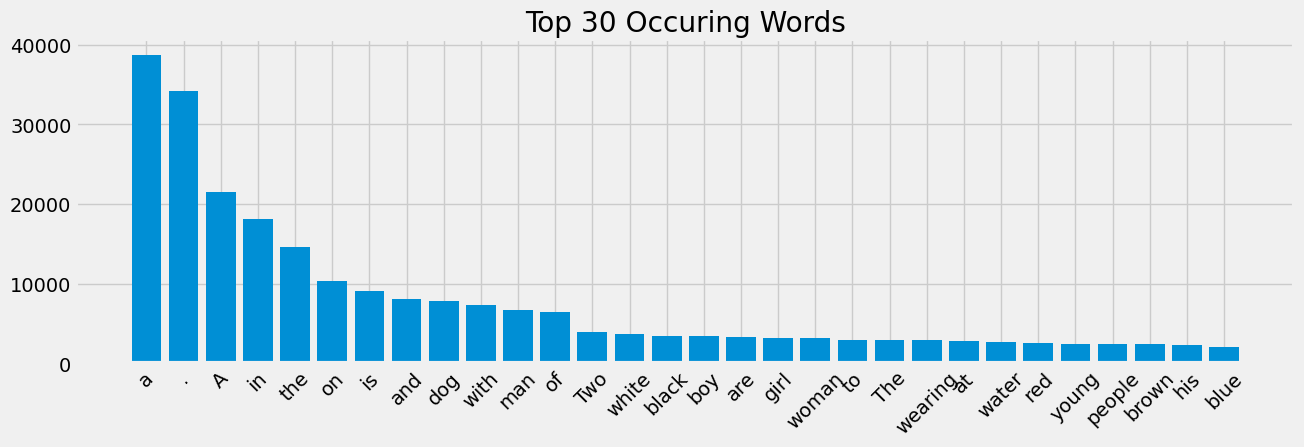

In [9]:
#Visualise the top 30 occuring words in the captions
def plot_top_words(word_counter):
    plt.style.use('fivethirtyeight')
    # plt.title('Most Commonly Used NOUNs')
    plt.figure(figsize=(14,4))
    plt.xticks(rotation=45)
    # plt.bar(*zip(*word_counter.most_common(30)))
    plt.bar(*zip(*word_counter))
    plt.title("Top 30 Occuring Words")
    plt.show()

plot_top_words(val_count.most_common(30))

## Step 3: Pre-Processing the captions
1.We create a tokenized vectors by tokenizing the captions for ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [10]:
# create the tokenizer

top_word_count = 5000

filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])
print(f'OOV Token: {tokenizer.oov_token}')


[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4], [3, 2, 20, 313, 64, 2, 197, 120, 4], [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4], [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4], [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']
OOV Token: <unk>


In [11]:
# Lets Create a word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Add Pad Token
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


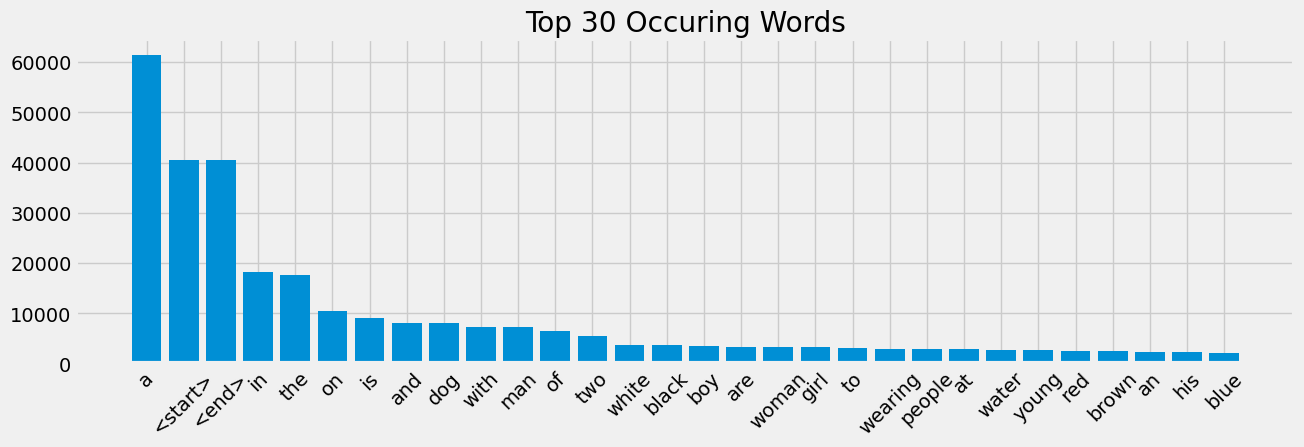

In [12]:
# Lets Create a word count of our tokenizer to visulize the Top 30 occuring words after text processing
sort_word_by_count = sorted(tokenizer.word_counts.items(), key=lambda kv : kv[1], reverse= True)
plot_top_words(sort_word_by_count[:30])

In [13]:
# Pad each vector to the max_length of the captions & store it to a vairable

max_sequence_len = max(len(t) for t in train_seqs)
print(f'Max Sequence Length of the Texts is: {max_sequence_len}')

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sequence_len)
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max Sequence Length of the Texts is: 35
The shape of Caption vector is :(40455, 35)


## Step 4: Pre-processing the images

1.Resize images into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

#### Tips to resize the images::
* Since we have a list which contains all the image path, we need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once we have created a dataset consisting of image paths, we need to apply a function to the dataset which will apply the necessary preprocessing to each image.
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [14]:
#lets create the dataset consisting of image paths
unique_img_vector = sorted (set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_vector)


I0000 00:00:1759223666.661434      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
#Code for creating the function. This function should return images & their path

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


In [16]:
#Applying the function to the image path dataset, such that the transformed dataset should contain images & their path

image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                .batch(64)
image_dataset



<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Step 5: Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, we extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.We Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [17]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input =image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model =tf.keras.Model(new_input, hidden_layer)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Directory to save features (writable in Kaggle)
save_dir = "/kaggle/working/features"
os.makedirs(save_dir, exist_ok=True)

# Applying the feature extraction model
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    # Reshape features to (batch_size, 8*8, 2048)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        # Extract just the filename from the original path
        filename = os.path.basename(p.numpy().decode("utf-8"))
        # Create the writable path for .npy file
        path_of_feature = os.path.join(save_dir, filename + ".npy")
        # Save the feature
        np.save(path_of_feature, bf.numpy())


100%|██████████| 127/127 [00:56<00:00,  2.23it/s]


## Step 6: Dataset creation
1.Applying train_test_split on both image path & captions to create the train & test list. Creating the train-test split using 80-20 ratio & random state = 42

2.Lets Create a function which maps the image path to their feature.

3.lets Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

4.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

5.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [19]:
#Lets split the data

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [20]:
# Checking the shape of train and Test data
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [21]:
# Lets Create a function which maps the image path to their feature.
# This function will take the image_path & caption and return it's feature & respective caption.

FEATURES_DIR = "/kaggle/working/features"

def map_func(image, caption):
    # Get just the filename (e.g., 359082432_c1fd5aa2d6.jpg)
    filename = os.path.basename(image.decode('utf-8'))
    # Build path to the .npy file in the writable folder
    feature_path = os.path.join(FEATURES_DIR, filename + ".npy")
    # Load the precomputed feature
    img_tensor = np.load(feature_path)
    # print(img_tensor.shape) 
    return img_tensor, caption


### Tips on how to load the features:
* We can load the features using the dictionary created earlier OR
* We can store using numpy(np.load) to load the feature vector.

In [22]:
# Lets create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image, caption,batch_size = 32,buffer_size=1000):

    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset



In [23]:
BATCH_SIZE=64
train_dataset=gen_dataset(path_train,cap_train,BATCH_SIZE)
test_dataset=gen_dataset(path_test,cap_test)

In [24]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


##  Step 7: Model Building
1.Set the parameters

2.Lets Build the Main : Encoder, Attention model & Decoder

In [25]:
#Set train and test Steps
embedding_dim = 256
units = 512
vocab_size =5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Defining Encoder

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim = 256):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build your Dense layer with relu activation

    def call(self, features):
        features =  self.dense(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [27]:
encoder=Encoder(embedding_dim)

### Defining Attention model

In [28]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units

    def call(self, features, hidden):
        # We received a hidden state with shape (512,). It should be (64, 512).
        # We will reshape to ensure the batch dimension is present.
        if len(hidden.shape) == 1:
            hidden = tf.expand_dims(hidden, axis=0) # Shape: (1, 512)
            
        # Add time axis for attention calculation
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Shape: (batch_size, 1, units)
        
        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))
        
        # score shape == (batch_size, 64, 1)
        score = self.V(attention_hidden_layer)
        
        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape == (batch_size, 64, embedding_dim)
        context_vector = attention_weights * features
        
        # context_vector shape after reduction == (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

###  Defining Decoder

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state, *extra = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [30]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [31]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Step 8: Model training & optimization
1.Lets Set the optimizer & loss object

2.Create our checkpoint path

3.Create our training & testing step functions

4.Create our loss function for the test dataset

In [32]:
# We will use Adam Optimizer
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [33]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [34]:
# Creating Checkpoints
# checkpoint_path = "./checkpoints/train"
checkpoint_path = os.path.join("checkpoints","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for our model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [36]:
# @tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))


    return loss, avg_loss

* While creating the test step for our model, we will pass our previous prediciton as the next input to the decoder.

In [37]:
# @tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
    #write your code here to do the training steps
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            predicted_id = tf.argmax(predictions,1)
            dec_input = tf.expand_dims(predicted_id, 1)

    avg_loss = (loss / int(target.shape[1]))

    return loss, avg_loss

In [38]:
def test_loss_cal(test_dataset):
    total_loss = 0


    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss,t_loss = test_step(img_tensor,target)
        total_loss += t_loss
    return total_loss/test_num_steps

In [39]:
#Lets fit the model
import time
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    
    print("Starting epoch:", epoch)

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()



  0%|          | 0/15 [00:00<?, ?it/s]

Starting epoch: 0
For epoch: 1, the train loss is 1.335, & test loss is 4.183
Time taken for 1 epoch 1227.0550620555878 sec

Test loss has been reduced from 100.000 to 4.183


  7%|▋         | 1/15 [20:27<4:46:23, 1227.36s/it]

Starting epoch: 1


 13%|█▎        | 2/15 [41:07<4:27:30, 1234.68s/it]

For epoch: 2, the train loss is 1.061, & test loss is 4.078
Time taken for 1 epoch 1239.627285003662 sec

Test loss has been reduced from 4.183 to 4.078
Starting epoch: 2


 20%|██        | 3/15 [1:01:56<4:08:15, 1241.28s/it]

For epoch: 3, the train loss is 0.975, & test loss is 4.018
Time taken for 1 epoch 1248.9616317749023 sec

Test loss has been reduced from 4.078 to 4.018
Starting epoch: 3


 27%|██▋       | 4/15 [1:22:34<3:47:22, 1240.25s/it]

For epoch: 4, the train loss is 0.918, & test loss is 3.902
Time taken for 1 epoch 1238.495100736618 sec

Test loss has been reduced from 4.018 to 3.902
Starting epoch: 4


 33%|███▎      | 5/15 [1:43:11<3:26:28, 1238.90s/it]

For epoch: 5, the train loss is 0.871, & test loss is 3.850
Time taken for 1 epoch 1236.3425722122192 sec

Test loss has been reduced from 3.902 to 3.850
Starting epoch: 5


 40%|████      | 6/15 [2:03:44<3:05:31, 1236.79s/it]

For epoch: 6, the train loss is 0.830, & test loss is 4.131
Time taken for 1 epoch 1232.696314573288 sec

Starting epoch: 6


 47%|████▋     | 7/15 [2:24:20<2:44:53, 1236.71s/it]

For epoch: 7, the train loss is 0.790, & test loss is 4.007
Time taken for 1 epoch 1236.556185722351 sec

Starting epoch: 7


 53%|█████▎    | 8/15 [2:45:34<2:25:40, 1248.66s/it]

For epoch: 8, the train loss is 0.756, & test loss is 3.947
Time taken for 1 epoch 1274.22429728508 sec

Starting epoch: 8


 60%|██████    | 9/15 [3:06:51<2:05:43, 1257.33s/it]

For epoch: 9, the train loss is 0.728, & test loss is 3.974
Time taken for 1 epoch 1276.4047803878784 sec

Starting epoch: 9


 67%|██████▋   | 10/15 [3:28:03<1:45:09, 1261.92s/it]

For epoch: 10, the train loss is 0.695, & test loss is 4.108
Time taken for 1 epoch 1272.1806671619415 sec

Starting epoch: 10


 73%|███████▎  | 11/15 [3:50:53<1:26:19, 1294.95s/it]

For epoch: 11, the train loss is 0.666, & test loss is 4.218
Time taken for 1 epoch 1369.8442595005035 sec

Starting epoch: 11


 80%|████████  | 12/15 [4:13:54<1:06:03, 1321.04s/it]

For epoch: 12, the train loss is 0.637, & test loss is 4.373
Time taken for 1 epoch 1380.7065641880035 sec

Starting epoch: 12


 87%|████████▋ | 13/15 [4:36:00<44:05, 1322.60s/it]  

For epoch: 13, the train loss is 0.618, & test loss is 4.339
Time taken for 1 epoch 1326.1863746643066 sec

Starting epoch: 13


 93%|█████████▎| 14/15 [4:58:14<22:05, 1325.97s/it]

For epoch: 14, the train loss is 0.594, & test loss is 4.530
Time taken for 1 epoch 1333.7613365650177 sec

Starting epoch: 14


100%|██████████| 15/15 [5:22:53<00:00, 1291.58s/it]

For epoch: 15, the train loss is 0.573, & test loss is 4.648
Time taken for 1 epoch 1479.6411175727844 sec



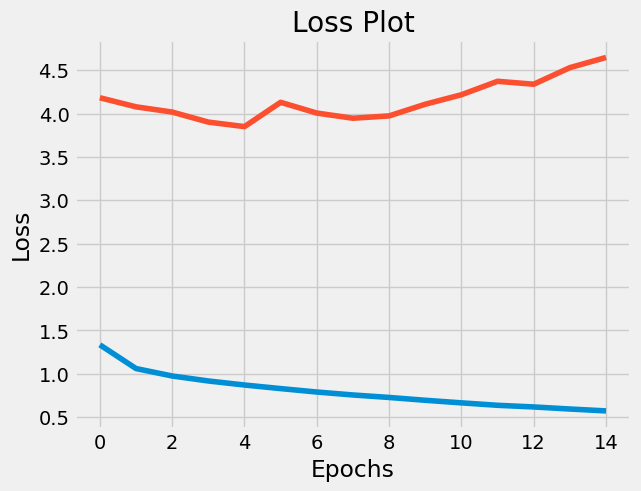

In [40]:
# Checking the plot of Loss vs Epochs
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE:
* Since there is a difference between the train & test steps ( Presence of teacher forcing), we may observe that the train loss is decreasing while your test loss is not.
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if we want to achieve better results we can run it more epochs, but the intent of this project is to get an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model.

## Step 9: Model Evaluation
1.We will define our evaluation function using greedy search

2.We will define our evaluation function using beam search

3.Test it on a sample data using BLEU score

### Greedy Search

In [41]:
# Using Greedy Search Evaluation method

attention_features_shape = 64

def evaluate(image):
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_sequence_len):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [42]:
# Evaluating using Beam Search

def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_sequence_len:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption


In [43]:
from PIL import Image
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [44]:
from nltk.translate.bleu_score import sentence_bleu

In [45]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [46]:
# Lets check the Verbose of the fitted image and the caption Generated:

def test_caption_generation(img_test):


    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    #test_image = './images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join(
        tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]
    )

    result, attention_plot,pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = [real_caption.split()]
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)

    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))
    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")

    plot_attmap(result, attention_plot, test_image)


    Image.open(test_image)

Real Caption: a dog looks behind itself
Prediction Caption: a group of dogs and weeds

BELU score: 
Individual 1-gram: 16.666666666666668
Individual 2-gram: 2.2250738585072627e-306
Individual 3-gram: 2.2250738585072627e-306
Individual 4-gram: 2.2250738585072627e-306


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

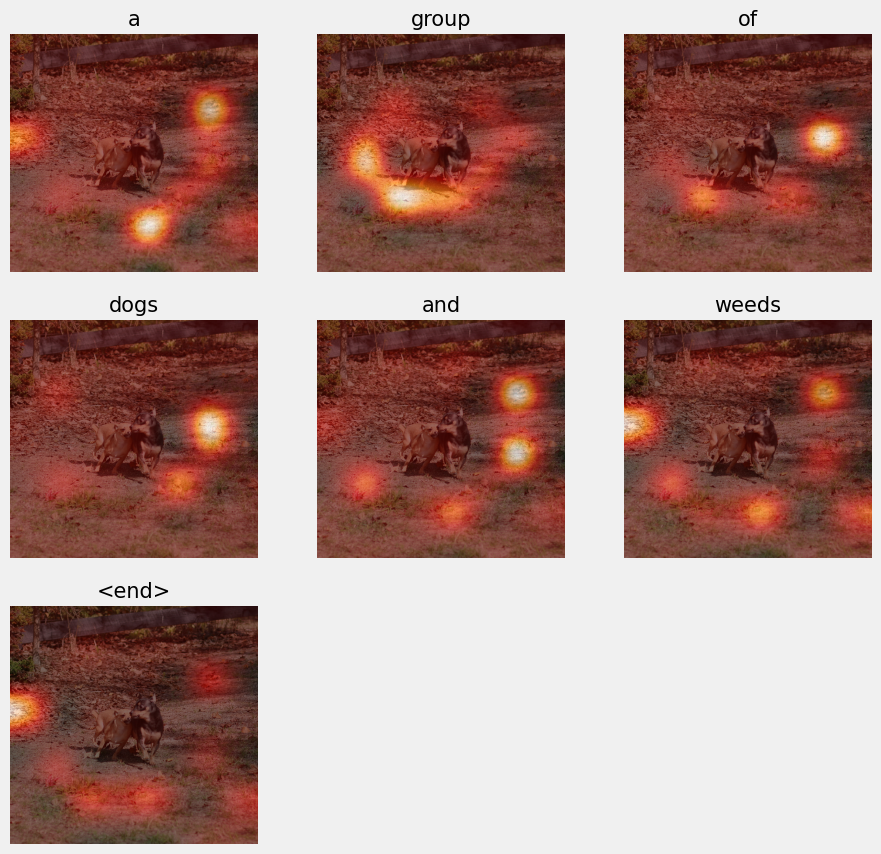

In [47]:

test_caption_generation(path_test)

### Evaluation with Unseen Data

In [48]:
# Install Required Libraries to Convert Text to Audio
!pip install pygame
!pip install gtts
import gtts
import pygame
# Libraries to convert text into audio
from gtts import gTTS
from IPython import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
pygame 2.6.1 (SDL 2.28.4, Python 3.11.13)
Hello from the pygame community. https://www.pygame.o

In [49]:
# Function to run the model on Test Image
def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    newsize = (800, 800)
    im = Image.open(openImg).resize(newsize)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))



    return im,pred_caption


Prediction Caption: a white and white dog jumps in his mouth

800 800


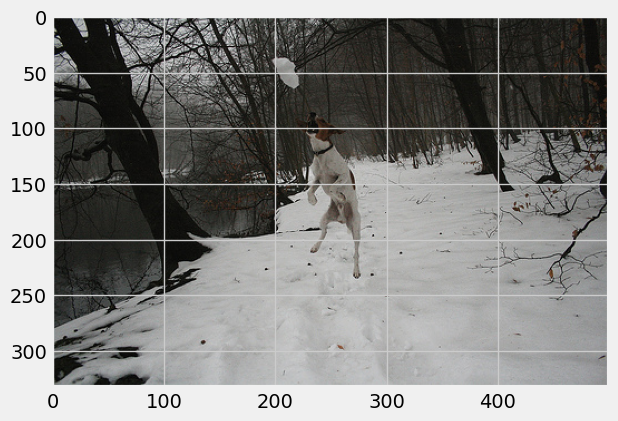

In [50]:
a,b=Prediction_Unknown_data(path_test[22])
plt.imshow(mpimg.imread(path_test[22]))
plt.show()

In [51]:
# make request to google to get synthesis
#Caption to audio conversion
soundFile = 'pred_caption.mp3'

tts = gTTS(b, slow = False)
tts.save(soundFile)

display.display(display.Audio(soundFile))

## Conclusion

"Eye for the Blind"

The "Eye for the Blind" project represents a remarkable innovation in the field of assistive technology, with a clear mission to provide a voice to those who cannot see. By combining state-of-the-art computer vision and natural language processing techniques, this project bridges the gap between the visual and auditory realms, allowing blind individuals to perceive, interpret, and understand the world around them in ways that were once unimaginable.

Key achievements of this project include:

1. **Encoder-Decoder Architecture**: The project leverages an Encoder-Decoder architecture, a deep learning model that has demonstrated remarkable capabilities in image captioning and language generation. The encoder extracts valuable information from images, while the decoder converts this information into coherent and descriptive spoken language.

2. **Attention Mechanism**: The attention mechanism is integrated into the model, allowing it to focus on relevant parts of an image while generating speech. This enhances the quality and accuracy of the spoken descriptions, ensuring a more detailed and contextually relevant experience for the users.

3. **Accessibility and Inclusivity**: "Eye for the Blind" promotes accessibility and inclusivity, making the world more navigable and comprehensible for the visually impaired. It provides them with a means to explore and understand their surroundings, including scenes, objects, and written text, through auditory feedback.

4. **Empowerment**: The project empowers visually impaired individuals to gain greater independence, education, and employment opportunities. By harnessing technology to deliver real-time spoken descriptions, it facilitates better engagement with the world and improved quality of life.

5. **Continuous Improvement**: The project is a testament to the ever-evolving field of artificial intelligence and its potential to transform lives. It demonstrates a commitment to ongoing research and development to enhance the system's accuracy, reliability, and user-friendliness.

In conclusion, "Eye for the Blind" serves as a remarkable example of the positive impact that technology can have on the lives of individuals with visual impairments. It enables them to explore the visual world through auditory senses, breaking down barriers and fostering greater independence. This project underscores the importance of accessibility, innovation, and the profound difference that technology can make in the lives of those it serves.

<h1><center><img src="https://i.pinimg.com/originals/e2/d7/c7/e2d7c71b09ae9041c310cb6b2e2918da.gif"></center></h1>